# ACRO Demonstration

In [1]:
import os
import sys
import pandas as pd
import numpy as np

In [2]:
# uncomment this line if acro is not installed
# ie you are in development mode
sys.path.insert(0, os.path.abspath(".."))

In [3]:
from acro import ACRO, add_constant, add_to_acro, utils

### Instantiate ACRO

In [4]:
acro = ACRO(suppress=True)

INFO:acro:version: 0.4.3
INFO:acro:config: {'safe_threshold': 10, 'safe_dof_threshold': 10, 'safe_nk_n': 2, 'safe_nk_k': 0.9, 'safe_pratio_p': 0.1, 'check_missing_values': False, 'survival_safe_threshold': 10}
INFO:acro:automatic suppression: True


### Load test data
The dataset used in this notebook is the nursery dataset from OpenML.  
- The dataset can be read directly from OpenML using the code commented in the next cell.
- In this version, it can be read directly from the local machine if it has been downloaded. 
- The code below reads the data from a folder called "data" which we assume is at the same level as the folder where you are working.
- The path might need to be changed if the data has been downloaded and stored elsewhere.
 - for example use:  
    path = os.path.join("data", "nursery.arff")  
    if the data is in a sub-folder of your work folder

In [5]:
from scipy.io.arff import loadarff

path = os.path.join("../data", "nursery.arff")
data = loadarff(path)
df = pd.DataFrame(data[0])
df = df.select_dtypes([object])
df = df.stack().str.decode("utf-8").unstack()
df.rename(columns={"class": "recommend"}, inplace=True)
df.head()

,parents,has_nurs,form,children,housing,finance,social,health,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


### Convert 'more than 3' children to random between 4 and 10
Change the children column from categorical to numeric in order to be able to test some of the ACRO functions that require a numeric feature

In [6]:
print(f" children column entries in raw file {df.children.unique()}")

 children column entries in raw file ['1' '2' '3' 'more']


In [7]:
df["children"].replace(to_replace={"more": "4"}, inplace=True)
df["children"] = pd.to_numeric(df["children"])

df["children"] = df.apply(
    lambda row: row["children"]
    if row["children"] in (1, 2, 3)
    else np.random.randint(4, 10),
    axis=1,
)

# Examples of producing tabular output
We rely on the industry-standard package **pandas** for tabulating data.  
In the next few examples we show:
- first, how a researcher would normally make a call in pandas, saving the results in a variable that they can view on screen (or save to file?)
- then how the call is identical in SACRO, except that:
  - "pd" is replaced by "acro"
  - the researcher immediately sees a copy of what the TRE output checker will see.
  

### Pandas crosstab
This is an example of crosstab using pandas.  
We first make the call, then the second line print the outputs to screen.

In [8]:
table = pd.crosstab(df.recommend, df.parents)
print(table)

parents     great_pret  pretentious  usual
recommend                                 
not_recom         1440         1440   1440
priority           858         1484   1924
recommend            0            0      2
spec_prior        2022         1264    758
very_recom           0          132    196


### ACRO crosstab
This is an example of crosstab using ACRO.  
The INFO lines show the researcher what will be reported to the output checkers.
Then the (suppressed as necessary)  table is shown via. the print command as before.

In [9]:
safe_table = acro.crosstab(df.recommend, df.parents)
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 4 cells suppressed; 
INFO:acro:outcome_df:
----------------------------------------------------|
parents    |great_pret   |pretentious  |usual       |
recommend  |             |             |            |
----------------------------------------------------|
not_recom  |          ok |          ok |          ok|
priority   |          ok |          ok |          ok|
recommend  | threshold;  | threshold;  | threshold; |
spec_prior |          ok |          ok |          ok|
very_recom | threshold;  |          ok |          ok|
----------------------------------------------------|

INFO:acro:records:add(): output_0


parents     great_pret  pretentious   usual
recommend                                  
not_recom       1440.0       1440.0  1440.0
priority         858.0       1484.0  1924.0
recommend          NaN          NaN     NaN
spec_prior      2022.0       1264.0   758.0
very_recom         NaN        132.0   196.0


### ACRO crosstab without supression
This is an example of crosstab without supressing the cells that violate the discloure tests.  
Note that you need to change the value of the supress variable in the acro object to False. Then run the crosstab command.  
If you wish to continue the research while supressing the outputs, turn on the supress variable otherwise leave it as it is.

In [10]:
acro.suppress = False

safe_table = acro.crosstab(df.recommend, df.parents)
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 4 cells may need suppressing; 
INFO:acro:outcome_df:
----------------------------------------------------|
parents    |great_pret   |pretentious  |usual       |
recommend  |             |             |            |
----------------------------------------------------|
not_recom  |          ok |          ok |          ok|
priority   |          ok |          ok |          ok|
recommend  | threshold;  | threshold;  | threshold; |
spec_prior |          ok |          ok |          ok|
very_recom | threshold;  |          ok |          ok|
----------------------------------------------------|

INFO:acro:records:add(): output_1


parents     great_pret  pretentious  usual
recommend                                 
not_recom         1440         1440   1440
priority           858         1484   1924
recommend            0            0      2
spec_prior        2022         1264    758
very_recom           0          132    196


In [11]:
acro.suppress = True

### ACRO crosstab with aggregation function

In [12]:
safe_table = acro.crosstab(df.recommend, df.parents, values=df.children, aggfunc="mean")
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 1 cells suppressed; p-ratio: 4 cells suppressed; nk-rule: 4 cells suppressed; 
INFO:acro:outcome_df:
------------------------------------------------------------------------------------|
parents    |great_pret          |pretentious         |usual                         |
recommend  |                    |                    |                              |
------------------------------------------------------------------------------------|
not_recom  |                 ok |                 ok |                            ok|
priority   |                 ok |                 ok |                            ok|
recommend  | p-ratio; nk-rule;  | p-ratio; nk-rule;  | threshold; p-ratio; nk-rule; |
spec_prior |                 ok |                 ok |                            ok|
very_recom | p-ratio; nk-rule;  |                 ok |                            ok|
-----------------------------------------------------------------------------------

parents     great_pret  pretentious     usual
recommend                                    
not_recom     3.127778     3.109722  3.140972
priority      2.594406     3.015499  3.142412
recommend          NaN          NaN       NaN
spec_prior    3.339763     3.333861  3.378628
very_recom         NaN     2.166667  2.239796


### ACRO pivot_table
This is an example of pivot table using ACRO.  
- Some researchers may prefer this to using crosstab.   
- Again the call syntax is identical to the pandas "pd.pivot_table"
- in this case the output is non-disclosive

In [13]:
table = acro.pivot_table(
    df, index=["parents"], values=["children"], aggfunc=["mean", "std"]
)
print(table)

INFO:acro:get_summary(): pass
INFO:acro:outcome_df:
------------------------------|
            mean     |std     |
            children |children|
parents              |        |
------------------------------|
great_pret   ok      | ok     |
pretentious  ok      | ok     |
usual        ok      | ok     |
------------------------------|

INFO:acro:records:add(): output_3


                 mean       std
             children  children
parents                        
great_pret   3.121065  2.235586
pretentious  3.114120  2.226508
usual        3.141435  2.264240


# Regression examples using ACRO

Again there is an industry-standard package in python, this time called **statsmodels**.
- The examples below illustrate the use of the ACRO wrapper standard statsmodel functions
- Note that statsmodels can be called using an 'R-like' format (using an 'r' suffix on the command names)
- most statsmodels functiobns return a "results object" which has a "summary" function that produces printable/saveable outputs 

### Start by manipulating the nursery data to get two numeric variables
- The 'recommend' column is converted to an integer scale

In [14]:
df["recommend"].replace(
    to_replace={
        "not_recom": "0",
        "recommend": "1",
        "very_recom": "2",
        "priority": "3",
        "spec_prior": "4",
    },
    inplace=True,
)
df["recommend"] = pd.to_numeric(df["recommend"])

new_df = df[["recommend", "children"]]
new_df = new_df.dropna()

### ACRO OLS 
This is an example of ordinary least square regression using ACRO.  
- Above recommend column was converted form categorical to numeric. 
- Now we perform a the linear regression between recommend and children. 
- This version includes a constant (intercept)
- This is just to show how the regression is done using ACRO.  
- **No correlation is expected to be seen by using these variables**

In [15]:
y = new_df["recommend"]
x = new_df["children"]
x = add_constant(x)

results = acro.ols(y, x)
results.summary()

INFO:acro:ols() outcome: pass; dof=12958.0 >= 10


INFO:acro:records:add(): output_4


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.675
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00561
Time:                        14:42:13   Log-Likelihood:                -25124.
No. Observations:               12960   AIC:                         5.025e+04
Df Residuals:                   12958   BIC:                         5.027e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2294      0.025     87.972      0.000       2.180       2.279
children       0.0183      0.007      2.770      0.006       0.005       0.031
==============================================================================
Omnibus:                    76796.580   Durbin-Watson:                   2.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1742.889
Skew:                          -0.485   Prob(JB):                         0.00
Kurtosis:                       1.488   Cond. No.                         6.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ACRO OLSR
This is an example of ordinary least squares regression using the 'R-like' statsmodels api, i.e. from a formula and dataframe using ACRO 

In [16]:
results = acro.olsr(formula="recommend ~ children", data=new_df)
print(results.summary())

INFO:acro:olsr() outcome: pass; dof=12958.0 >= 10


INFO:acro:records:add(): output_5


                            OLS Regression Results                            
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.675
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00561
Time:                        14:42:13   Log-Likelihood:                -25124.
No. Observations:               12960   AIC:                         5.025e+04
Df Residuals:                   12958   BIC:                         5.027e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2294      0.025     87.972      0.0

### ACRO Probit
This is an example of probit regression using ACRO  
We use a different combination of variables from the original dataset.

Again, we support the use of R-lijke formulas - because we suprort R 

In [17]:
new_df = df[["finance", "children"]]
new_df = new_df.dropna()

y = new_df["finance"].astype("category").cat.codes  # numeric
y.name = "finance"
x = new_df["children"]
x = add_constant(x)

results = acro.probit(y, x)
print(results.summary())

Optimization terminated successfully.

INFO:acro:probit() outcome: pass; dof=12958.0 >= 10


INFO:acro:records:add(): output_6



         Current function value: 0.693136
         Iterations 3
                          Probit Regression Results                           
Dep. Variable:                finance   No. Observations:                12960
Model:                         Probit   Df Residuals:                    12958
Method:                           MLE   Df Model:                            1
Date:                Thu, 31 Aug 2023   Pseudo R-squ.:               1.604e-05
Time:                        14:42:13   Log-Likelihood:                -8983.0
converged:                       True   LL-Null:                       -8983.2
Covariance Type:            nonrobust   LLR p-value:                    0.5914
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0082      0.019     -0.436      0.663      -0.045       0.029
children       0.0026      0.005      0.537      0.591      -0.007

### ACRO Logit
This is an example of logistic regression using ACRO using the statmodels function

In [18]:
results = acro.logit(y, x)
results.summary()

INFO:acro:logit() outcome: pass; dof=12958.0 >= 10
INFO:acro:records:add(): output_7


Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                finance   No. Observations:                12960
Model:                          Logit   Df Residuals:                    12958
Method:                           MLE   Df Model:                            1
Date:                Thu, 31 Aug 2023   Pseudo R-squ.:               1.604e-05
Time:                        14:42:13   Log-Likelihood:                -8983.0
converged:                       True   LL-Null:                       -8983.2
Covariance Type:            nonrobust   LLR p-value:                    0.5914
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0131      0.030     -0.436      0.663      -0.072       0.046
children       0.0042      0.008      0.537      0.591      -0.011       0.020
==============================================================================
"""

### ACRO survival analysis
This is an example of survival tables and plots using ACRO.  
- A dataset from statsmodels is used for the survival analysis.
- The output parameter in the surv_func define the type of output (table or plot).

In [19]:
import statsmodels.api as sm

data = sm.datasets.get_rdataset("flchain", "survival").data
data = data.loc[data.sex == "F", :]
# data.head()

In [20]:
safe_table = acro.surv_func(data.futime, data.death, output="table")
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 3864 cells suppressed; 


INFO:acro:outcome_df:
-----------------------------------------------------------------|
     |Surv| |prob    Surv prob |SE ||num| at| risk  num |events  |
Time |    | |                  |   ||   |   |           |        |
-----------------------------------------------------------------|
0    |    | |     ok           |ok ||   |   |    ok     |      ok|
1    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
2    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
3    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
4    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
5    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
6    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
7    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
8    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
9    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
11   | thr|e|shold;   threshold|;  || th

      Surv prob  Surv prob SE  num at risk  num events
Time                                                  
0      0.999310      0.000398       4350.0         3.0
1           NaN           NaN          NaN         NaN
2           NaN           NaN          NaN         NaN
3           NaN           NaN          NaN         NaN
4           NaN           NaN          NaN         NaN
...         ...           ...          ...         ...
4823   0.701510      0.007615        951.0         1.0
4891   0.700487      0.007673        686.0         1.0
4914   0.699280      0.007754        580.0         1.0
4928   0.697823      0.007873        480.0         1.0
4998   0.690844      0.010439        100.0         1.0

[1027 rows x 4 columns]


INFO:acro:get_summary(): fail; threshold: 3864 cells suppressed; 


INFO:acro:outcome_df:
-----------------------------------------------------------------|
     |Surv| |prob    Surv prob |SE ||num| at| risk  num |events  |
Time |    | |                  |   ||   |   |           |        |
-----------------------------------------------------------------|
0    |    | |     ok           |ok ||   |   |    ok     |      ok|
1    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
2    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
3    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
4    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
5    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
6    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
7    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
8    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
9    | thr|e|shold;   threshold|;  || th|res|hold;   thr|eshold; |
11   | thr|e|shold;   threshold|;  || th

Axes(0.125,0.11;0.775x0.77)


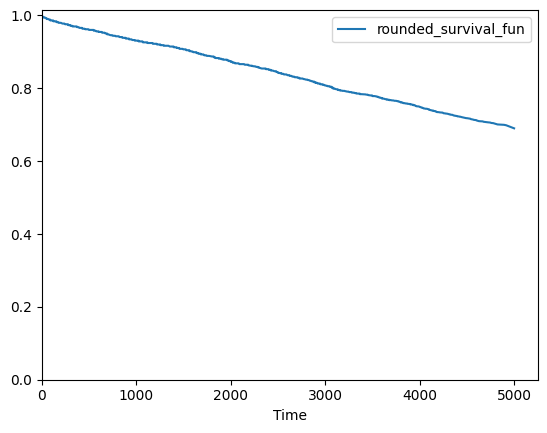

In [21]:
safe_plot = acro.surv_func(
    data.futime, data.death, output="plot", filename="kaplan-mier.png"
)
print(safe_plot)

# ACRO functionality to let users manage their outputs

### 1: List current ACRO outputs
This is an example of using the print_output function to list all the outputs created so far

In [22]:
acro.print_outputs()

uid: output_0
status: fail
type: table
properties: {'method': 'crosstab'}
sdc: {'summary': {'suppressed': True, 'negative': 0, 'missing': 0, 'threshold': 4, 'p-ratio': 0, 'nk-rule': 0}, 'cells': {'negative': [], 'missing': [], 'threshold': [[2, 0], [2, 1], [2, 2], [4, 0]], 'p-ratio': [], 'nk-rule': []}}
command: safe_table = acro.crosstab(df.recommend, df.parents)
summary: fail; threshold: 4 cells suppressed; 
outcome: parents      great_pret  pretentious        usual
recommend                                        
not_recom            ok           ok           ok
priority             ok           ok           ok
recommend   threshold;   threshold;   threshold; 
spec_prior           ok           ok           ok
very_recom  threshold;            ok           ok
output: [parents     great_pret  pretentious   usual
recommend                                  
not_recom       1440.0       1440.0  1440.0
priority         858.0       1484.0  1924.0
recommend          NaN          NaN     Na

'uid: output_0\nstatus: fail\ntype: table\nproperties: {\'method\': \'crosstab\'}\nsdc: {\'summary\': {\'suppressed\': True, \'negative\': 0, \'missing\': 0, \'threshold\': 4, \'p-ratio\': 0, \'nk-rule\': 0}, \'cells\': {\'negative\': [], \'missing\': [], \'threshold\': [[2, 0], [2, 1], [2, 2], [4, 0]], \'p-ratio\': [], \'nk-rule\': []}}\ncommand: safe_table = acro.crosstab(df.recommend, df.parents)\nsummary: fail; threshold: 4 cells suppressed; \noutcome: parents      great_pret  pretentious        usual\nrecommend                                        \nnot_recom            ok           ok           ok\npriority             ok           ok           ok\nrecommend   threshold;   threshold;   threshold; \nspec_prior           ok           ok           ok\nvery_recom  threshold;            ok           ok\noutput: [parents     great_pret  pretentious   usual\nrecommend                                  \nnot_recom       1440.0       1440.0  1440.0\npriority         858.0       1484.0  1

### 2: Remove some ACRO outputs before finalising 
This is an example of deleting some of the ACRO outputs.  
The name of the output that needs to be removed should be passed to the function remove_output.  
- Currently, all outputs names contain timestamp; that is the time when the output was created.  
- The output name can be taken from the outputs listed by the print_outputs function, 
- or by listing the results and choosing the specific output that needs to be removed

In [23]:
acro.remove_output("output_0")

INFO:acro:records:remove(): output_0 removed


### 3: Rename ACRO outputs before finalising
This is an example of renaming the outputs to provide a more descriptive name.  
The timestamp associated with the output name will not get overwritten

In [24]:
acro.rename_output("output_2", "pivot_table")

INFO:acro:records:rename_output(): output_2 renamed to pivot_table


### 4: Add a comment to output
This is an example to add a comment to outputs.  
It can be used to provide a description or to pass additional information to the output checkers.

In [25]:
acro.add_comments("output_1", "Please let me have this data.")
acro.add_comments("output_1", "6 cells were supressed in this table")

INFO:acro:records:a comment was added to output_1
INFO:acro:records:a comment was added to output_1


### 5: Add an unsupported output to the list of outputs
This is an example to add an unsupported outputs (such as images) to the list of outputs

In [26]:
acro.custom_output(
    "XandY.jpeg", "This output is an image showing the relationship between X and Y"
)

INFO:acro:records:add_custom(): output_10


## 6: (the big one) Finalise ACRO
This is an example of the function _finalise()_ which the users must call at the end of each session.  
- It takes each output and saves it to a CSV file.    
- It also saves the SDC analysis for each output to a json file or Excel file  
  (depending on the extension of the name of the file provided as an input to the function)

In [27]:
output = acro.finalise("NURSERY", "json")

INFO:acro:records:
uid: output_1
status: fail
type: table
properties: {'method': 'crosstab'}
sdc: {'summary': {'suppressed': False, 'negative': 0, 'missing': 0, 'threshold': 4, 'p-ratio': 0, 'nk-rule': 0}, 'cells': {'negative': [], 'missing': [], 'threshold': [[2, 0], [2, 1], [2, 2], [4, 0]], 'p-ratio': [], 'nk-rule': []}}
command: safe_table = acro.crosstab(df.recommend, df.parents)
summary: fail; threshold: 4 cells may need suppressing; 
outcome: parents      great_pret  pretentious        usual
recommend                                        
not_recom            ok           ok           ok
priority             ok           ok           ok
recommend   threshold;   threshold;   threshold; 
spec_prior           ok           ok           ok
very_recom  threshold;            ok           ok
output: [parents     great_pret  pretentious  usual
recommend                                 
not_recom         1440         1440   1440
priority           858         1484   1924
recommend       

### 7: Add a directory of outputs to an acro object 
This is an example of adding a list of files (produced by the researcher without using ACRO) to an acro object and creates a results file for checking.

In [28]:
import shutil

table = pd.crosstab(df.recommend, df.parents)
# save the output table to a file and add this file to a directory
src_path = "test_add_to_acro"
file_path = "crosstab.pkl"
dest_path = "SDC_results"
if not os.path.exists(src_path):
    table.to_pickle(file_path)
    os.mkdir(src_path)
    shutil.move(file_path, src_path, copy_function=shutil.copytree)

# add the output to acro
add_to_acro(src_path, dest_path)

INFO:acro:version: 0.4.3
INFO:acro:config: {'safe_threshold': 10, 'safe_dof_threshold': 10, 'safe_nk_n': 2, 'safe_nk_k': 0.9, 'safe_pratio_p': 0.1, 'check_missing_values': False, 'survival_safe_threshold': 10}
INFO:acro:automatic suppression: False
INFO:acro:records:add_custom(): output_0
INFO:acro:records:rename_output(): output_0 renamed to crosstab.pkl
INFO:acro:records:
uid: crosstab.pkl
status: review
type: custom
properties: {}
sdc: {}
command: custom
summary: review
outcome: Empty DataFrame
Columns: []
Index: []
output: ['test_add_to_acro\\crosstab.pkl']
timestamp: 2023-08-31T14:42:19.204053
comments: ['']
exception: 

The status of the record above is: review.
Please explain why an exception should be granted.

INFO:acro:records:outputs written to: SDC_results
